In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import os
from io import BytesIO
from datetime import timezone
import matplotlib

In [2]:
RE_SPACE = re.compile(r'[\s]+')

In [3]:
path = "BENCHMARKS/csv_stuff-20210425074213/block128m_transfer1mb_ioop-z"

In [4]:
def print_data(fpath):
    start = None
    end = None
    ordering = None
    xfersize = None
    r_tp = None
    w_tp = None
    r_iops = None
    w_iops = None
    time_taken = None

    with open(fpath+"/ior_op.dat", 'r') as f:
        for line in f:
            if "StartTime" in line:
                start = line.split(": ")[1].strip()
                start = datetime.strptime(start, '%a %b %d %H:%M:%S %Y')
            if "ordering in a file" in line:
                ordering = line.split(": ")[1].strip()
            if "xfersize" in line:
                xfersize = line.split(": ")[1].strip()
            if "Finished" in line:
                end = line.split(": ")[1].strip()
                end = datetime.strptime(end, '%a %b %d %H:%M:%S %Y')
            if "bw(MiB/s)" in line:
                line = next(f)
                line = next(f)
                x = re.split(RE_SPACE, line)
                w_tp = float(x[1])
                w_iops = float(x[2])

                line = next(f)
                x = re.split(RE_SPACE, line)
                r_tp = float(x[1])
                r_iops = float(x[2])

    time_taken = end-start
#     print("{} - {} = {}".format(end, start, time_taken))
#     print(xfersize)
#     print(w_tp, w_iops)
#     print(r_tp, r_iops)
    return ordering, xfersize, r_tp, w_tp, r_iops, w_iops, start, end

In [5]:
def read_csv(file_path):
    
    content = ""
    with open(file_path, 'r') as f:
        for line in f.readlines():
            if "#" in line:
                header = line
            else:
                content += line

    content = header+content
    content_stream = BytesIO(content.encode())
    df = pd.read_csv(content_stream, delimiter=';')
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    content_stream.close()
    return df

In [6]:
def get_network(df, start, end):
    start = start.replace(tzinfo=timezone.utc)
    end = end.replace(tzinfo=timezone.utc)

    df1 = df[(df['timestamp'] > start) & (df['timestamp'] < end)]
    
    df1 = df1[df1['IFACE'] == "eno1"]
    
    grpd = df1.groupby("# hostname")
    s1_df = grpd.get_group("an-sap-s-1").reset_index(drop=True)
    s2_df = grpd.get_group("an-sap-s-2").reset_index(drop=True)
    
    s1_df = s1_df[["rxkB/s", "txkB/s"]]
    s2_df = s2_df[["rxkB/s", "txkB/s"]]
    
    s3_df = pd.DataFrame()
    s3_df["rxkB/s"] = s1_df["rxkB/s"] + s2_df["rxkB/s"]
    s3_df["txkB/s"] = s1_df["txkB/s"] + s2_df["txkB/s"]
    
#     s1_df.plot()
#     s2_df.plot()
#     s3_df.plot()
    return s3_df

In [7]:
def get_io(df, start, end):
    start = start.replace(tzinfo=timezone.utc)
    end = end.replace(tzinfo=timezone.utc)

    df1 = df[(df['timestamp'] > start) & (df['timestamp'] < end)]
    
    df1 = df1[df1["DEV"]=="sda"].reset_index(drop=True)
    
    grpd = df1.groupby("# hostname")
    s1_df = grpd.get_group("an-sap-s-1").reset_index(drop=True)
    s2_df = grpd.get_group("an-sap-s-2").reset_index(drop=True)
    
    s1_df = s1_df[["rkB/s", "wkB/s"]]
    s2_df = s2_df[["rkB/s", "wkB/s"]]
    
    s3_df = pd.DataFrame()
    s3_df["rkB/s"] = s1_df["rkB/s"] + s2_df["rkB/s"]
    s3_df["wkB/s"] = s1_df["wkB/s"] + s2_df["wkB/s"]
    
#     s1_df.plot()
#     s2_df.plot()
#     s3_df.plot()
    return s3_df

In [8]:
def get_cpu(df, start, end):
    start = start.replace(tzinfo=timezone.utc)
    end = end.replace(tzinfo=timezone.utc)

    df1 = df[(df['timestamp'] > start) & (df['timestamp'] < end)]
    
    grpd = df1.groupby("# hostname")
    s1_df = grpd.get_group("an-sap-s-1").reset_index(drop=True)
    s2_df = grpd.get_group("an-sap-s-2").reset_index(drop=True)
    
    s1_df = s1_df[["%sys", "%iowait"]]
    s2_df = s2_df[["%sys", "%iowait"]]
    
    s3_df = pd.DataFrame()
    s3_df["%sys"] = s1_df["%sys"] + s2_df["%sys"]
    s3_df["%iowait"] = s1_df["%iowait"] + s2_df["%iowait"]
    
#     s1_df.plot()
#     s2_df.plot()
#     s3_df.plot()
    return s3_df

In [9]:
final_path = "final_data"
di = {}
for fs in os.listdir(final_path):
    di[fs] = {}
    print(fs)
    print("="*10)
    for bsize in os.listdir(final_path+"/"+fs):
        di[fs][bsize] = []
        print(bsize)
        print("-"*10)
        b_path = final_path+"/"+fs + "/"+bsize+"/"
        b_path = b_path+"/"+os.listdir(b_path)[0]
        start, end = None, None
        cpu_df, io_df, net_df = None, None, None
        for file in os.listdir(b_path):
            if "netdev.csv" in file:
                net_df = read_csv(b_path+"/netdev.csv")
            if "io.csv" in file:
                io_df = read_csv(b_path+"/io.csv")
            if "cpu.csv" in file:
                cpu_df = read_csv(b_path+"/cpu.csv")
        for file in os.listdir(b_path):
            if "block" in file:
                dff = pd.DataFrame()
                ior_path = b_path+"/"+file
                dat = print_data(ior_path)
                net = get_network(net_df, dat[-2], dat[-1])
                io = get_io(io_df, dat[-2], dat[-1])
                cpu = get_cpu(cpu_df, dat[-2], dat[-1])
                dff = pd.concat([io, cpu, net], axis=1)
                di[fs][bsize] = dff.dropna()
#         break
#     break
print(di)

btrfs
default_4KB
----------
ext4
1KB
----------
2KB
----------
default_4KB
----------
f2fs
default_512k
----------
xfs
1KB
----------
2KB
----------
default_4KB
----------
{'btrfs': {'default_4KB':        rkB/s      wkB/s  %sys  %iowait     rxkB/s    txkB/s
0        0.0   52348.00  0.54     5.00   29585.84  30733.87
1        0.0   97632.00  0.98     3.13   60933.84    219.94
2        0.0  123824.16  1.05     1.82   94589.01    332.29
3        0.0  164228.00  1.55     2.15  107716.28    368.10
4        0.0  177024.00  1.54     2.32  150533.30    525.29
..       ...        ...   ...      ...        ...       ...
246  29184.0    2120.00  0.28    37.55     133.97  30237.80
247  32448.0       0.00  0.40    36.98      58.45  12430.85
248  31552.0       0.00  0.40    32.04     164.07  35749.92
249  28160.0      28.00  0.36    31.32     156.50  34138.35
250  29632.0      60.00  0.34    23.75     142.27  30753.48

[251 rows x 6 columns]}, 'ext4': {'1KB':        rkB/s    wkB/s  %sys  %iowait   

In [10]:
dop = {}
for fs, val in di.items():
    for bs, bsv in val.items():
        dop[fs+"_"+bs] = bsv.sum()

In [11]:
df_oh = pd.DataFrame(dop).T.sort_index()

In [12]:
df_oh

,rkB/s,wkB/s,%sys,%iowait,rxkB/s,txkB/s
btrfs_default_4KB,6260277.86,6385872.04,129.71,7832.66,6643261.75,6572627.93
ext4_1KB,6266900.32,6552486.82,113.94,4427.65,6643665.33,6580614.49
ext4_2KB,6281252.14,6472884.01,109.71,3784.91,6643677.37,6658000.94
ext4_default_4KB,6259049.58,6464998.21,106.38,3477.95,6643699.30,6623369.30
f2fs_default_512k,6286636.35,6286577.47,78.48,3888.31,6643731.04,6605357.95
xfs_1KB,6288718.04,6698812.55,88.15,4283.85,6643734.30,6637334.53
xfs_2KB,6266347.09,6388963.36,86.17,4507.29,6642307.24,6626367.13
xfs_default_4KB,6281430.33,6387974.67,88.79,3577.33,6643131.22,6634675.54


In [13]:
df_oh['w_oh(Mb)'] = (df_oh["rxkB/s"] - 6291456)/1024
df_oh['r_oh(Mb)'] = (df_oh["txkB/s"] - 6291456)/1024

df_oh['%iowait'] = df_oh['%iowait']/len(df_oh)
df_oh['%sys'] = df_oh['%sys']/len(df_oh)

In [14]:
df_oh

,rkB/s,wkB/s,%sys,%iowait,rxkB/s,txkB/s,w_oh(Mb),r_oh(Mb)
btrfs_default_4KB,6260277.86,6385872.04,16.21375,979.08250,6643261.75,6572627.93,343.560303,274.581963
ext4_1KB,6266900.32,6552486.82,14.24250,553.45625,6643665.33,6580614.49,343.954424,282.381338
ext4_2KB,6281252.14,6472884.01,13.71375,473.11375,6643677.37,6658000.94,343.966182,357.954043
ext4_default_4KB,6259049.58,6464998.21,13.29750,434.74375,6643699.30,6623369.30,343.987598,324.134082
f2fs_default_512k,6286636.35,6286577.47,9.81000,486.03875,6643731.04,6605357.95,344.018594,306.544873
xfs_1KB,6288718.04,6698812.55,11.01875,535.48125,6643734.30,6637334.53,344.021777,337.772002
xfs_2KB,6266347.09,6388963.36,10.77125,563.41125,6642307.24,6626367.13,342.628164,327.061650
xfs_default_4KB,6281430.33,6387974.67,11.09875,447.16625,6643131.22,6634675.54,343.432832,335.175332


(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(-1.0, 0, 'xfs_default_4KB'),
  Text(0.0, 0, 'btrfs_default_4KB'),
  Text(1.0, 0, 'ext4_1KB'),
  Text(2.0, 0, 'ext4_2KB'),
  Text(3.0, 0, 'ext4_default_4KB'),
  Text(4.0, 0, 'f2fs_default_512k'),
  Text(5.0, 0, 'xfs_1KB'),
  Text(6.0, 0, 'xfs_2KB'),
  Text(7.0, 0, 'xfs_default_4KB'),
  Text(8.0, 0, '')])

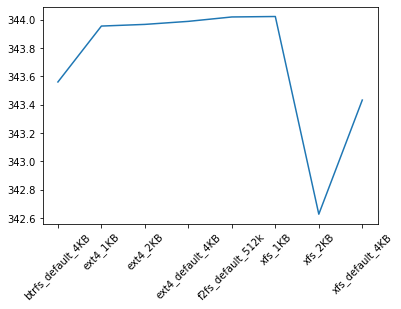

In [15]:
df_oh["w_oh(Mb)"].plot()
plt.xticks(rotation=45)

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(-1.0, 0, 'xfs_default_4KB'),
  Text(0.0, 0, 'btrfs_default_4KB'),
  Text(1.0, 0, 'ext4_1KB'),
  Text(2.0, 0, 'ext4_2KB'),
  Text(3.0, 0, 'ext4_default_4KB'),
  Text(4.0, 0, 'f2fs_default_512k'),
  Text(5.0, 0, 'xfs_1KB'),
  Text(6.0, 0, 'xfs_2KB'),
  Text(7.0, 0, 'xfs_default_4KB'),
  Text(8.0, 0, '')])

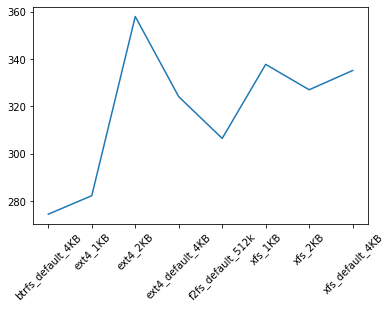

In [16]:
df_oh["r_oh(Mb)"].plot()
plt.xticks(rotation=45)

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(-1.0, 0, 'xfs_default_4KB'),
  Text(0.0, 0, 'btrfs_default_4KB'),
  Text(1.0, 0, 'ext4_1KB'),
  Text(2.0, 0, 'ext4_2KB'),
  Text(3.0, 0, 'ext4_default_4KB'),
  Text(4.0, 0, 'f2fs_default_512k'),
  Text(5.0, 0, 'xfs_1KB'),
  Text(6.0, 0, 'xfs_2KB'),
  Text(7.0, 0, 'xfs_default_4KB'),
  Text(8.0, 0, '')])

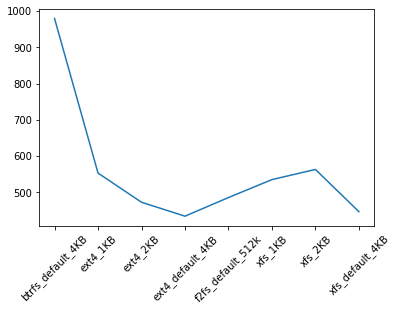

In [17]:
df_oh["%iowait"].plot()
plt.xticks(rotation=45)

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(-1.0, 0, 'xfs_default_4KB'),
  Text(0.0, 0, 'btrfs_default_4KB'),
  Text(1.0, 0, 'ext4_1KB'),
  Text(2.0, 0, 'ext4_2KB'),
  Text(3.0, 0, 'ext4_default_4KB'),
  Text(4.0, 0, 'f2fs_default_512k'),
  Text(5.0, 0, 'xfs_1KB'),
  Text(6.0, 0, 'xfs_2KB'),
  Text(7.0, 0, 'xfs_default_4KB'),
  Text(8.0, 0, '')])

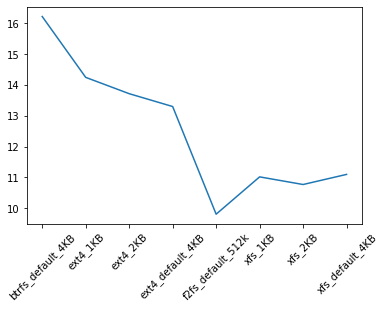

In [18]:
df_oh["%sys"].plot()
plt.xticks(rotation=45)

In [19]:
oh = {}
for fs, val in di.items():
    for bs, bsv in val.items():
        oh[fs+"_"+bs] = bsv

<AxesSubplot:>

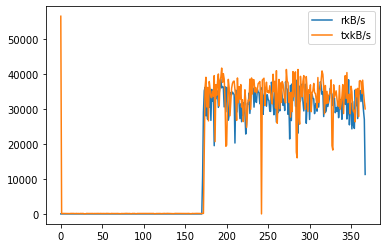

In [20]:
oh['ext4_2KB'][['rkB/s', 'txkB/s']].plot()

<AxesSubplot:>

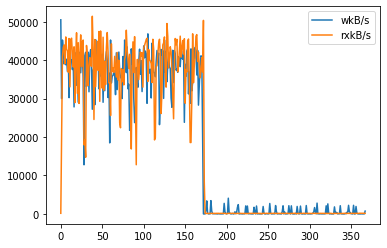

In [21]:
oh['ext4_2KB'][['wkB/s', 'rxkB/s']].plot()

In [22]:
oh.keys()

dict_keys(['btrfs_default_4KB', 'ext4_1KB', 'ext4_2KB', 'ext4_default_4KB', 'f2fs_default_512k', 'xfs_1KB', 'xfs_2KB', 'xfs_default_4KB'])

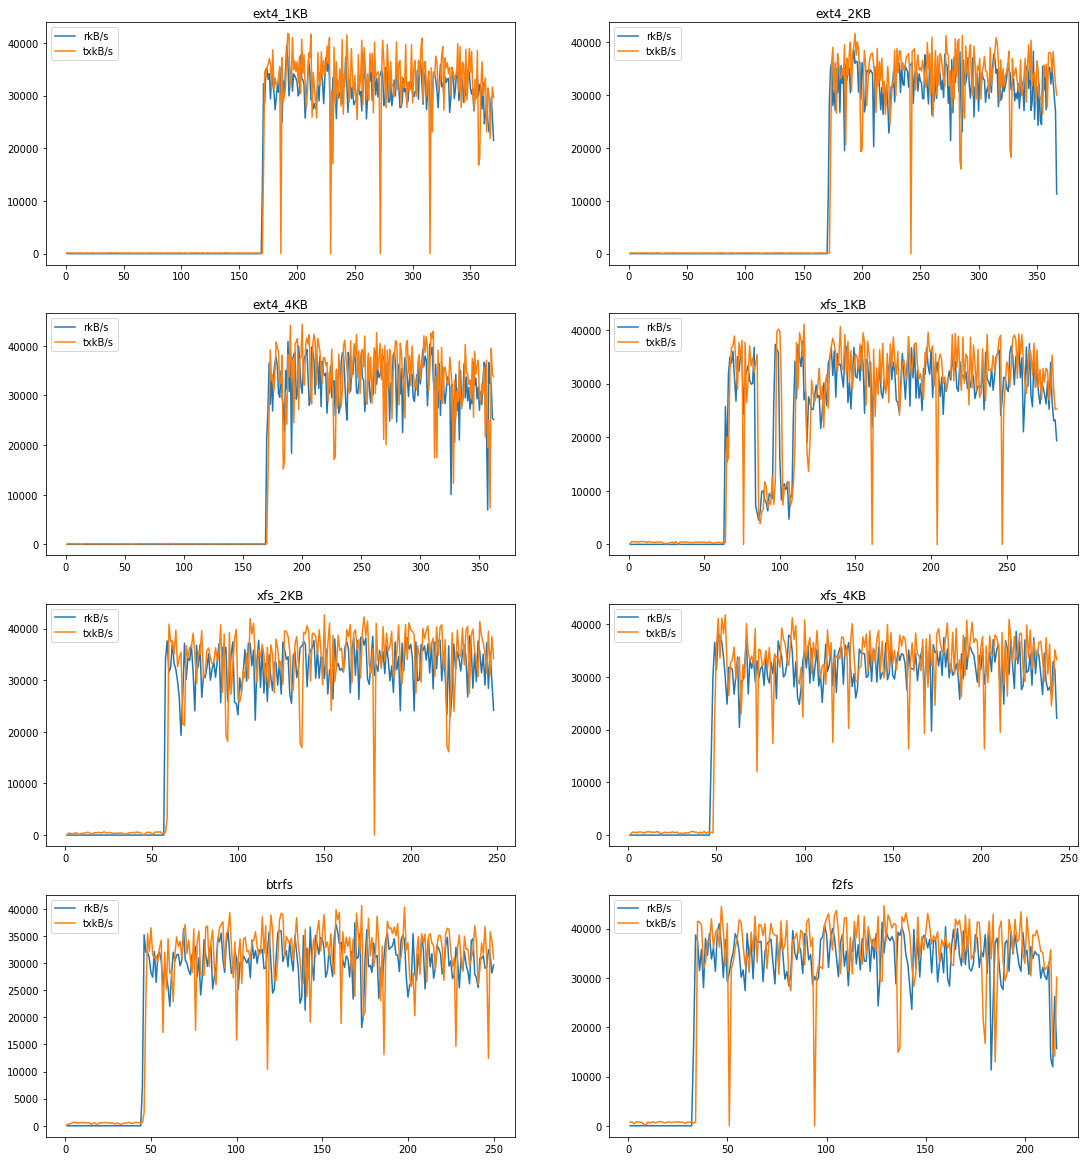

In [23]:
fig, axes = plt.subplots(nrows=4, ncols=2)

oh['ext4_1KB'][1:][['rkB/s', 'txkB/s']].plot(ax=axes[0, 0], title="ext4_1KB")
oh['ext4_2KB'][1:][['rkB/s', 'txkB/s']].plot(ax=axes[0, 1], title="ext4_2KB")
oh['ext4_default_4KB'][1:][['rkB/s', 'txkB/s']].plot(ax=axes[1, 0], title="ext4_4KB")
oh['xfs_1KB'][1:][['rkB/s', 'txkB/s']].plot(ax=axes[1, 1], title="xfs_1KB")
oh['xfs_2KB'][1:][['rkB/s', 'txkB/s']].plot(ax=axes[2, 0], title="xfs_2KB")
oh['xfs_default_4KB'][1:][['rkB/s', 'txkB/s']].plot(ax=axes[2, 1], title="xfs_4KB")
oh['btrfs_default_4KB'][1:][['rkB/s', 'txkB/s']].plot(ax=axes[3, 0], title="btrfs")
oh['f2fs_default_512k'][1:][['rkB/s', 'txkB/s']].plot(ax=axes[3, 1], title="f2fs")

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 20.5)

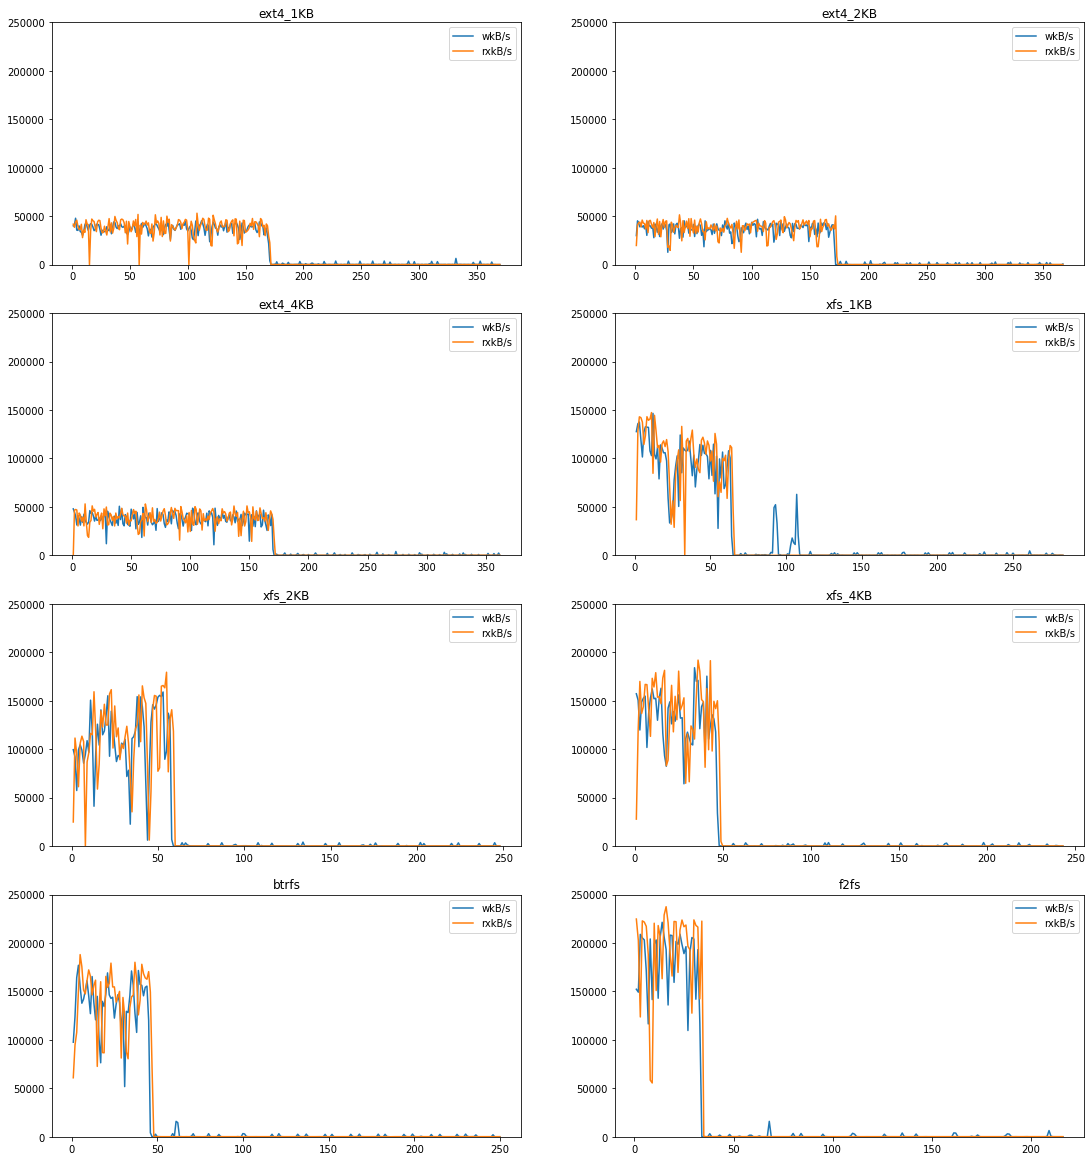

In [24]:
fig, axes = plt.subplots(nrows=4, ncols=2)

oh['ext4_1KB'][1:][['wkB/s', 'rxkB/s']].plot(ax=axes[0, 0], title="ext4_1KB")
oh['ext4_2KB'][1:][['wkB/s', 'rxkB/s']].plot(ax=axes[0, 1], title="ext4_2KB")
oh['ext4_default_4KB'][1:][['wkB/s', 'rxkB/s']].plot(ax=axes[1, 0], title="ext4_4KB")
oh['xfs_1KB'][1:][['wkB/s', 'rxkB/s']].plot(ax=axes[1, 1], title="xfs_1KB")
oh['xfs_2KB'][1:][['wkB/s', 'rxkB/s']].plot(ax=axes[2, 0], title="xfs_2KB")
oh['xfs_default_4KB'][1:][['wkB/s', 'rxkB/s']].plot(ax=axes[2, 1], title="xfs_4KB")
oh['btrfs_default_4KB'][1:][['wkB/s', 'rxkB/s']].plot(ax=axes[3, 0], title="btrfs")
oh['f2fs_default_512k'][1:][['wkB/s', 'rxkB/s']].plot(ax=axes[3, 1], title="f2fs")

custom_xlim = (0, 400)
custom_ylim = (0, 250000)
plt.setp(axes, ylim=custom_ylim)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 20.5)

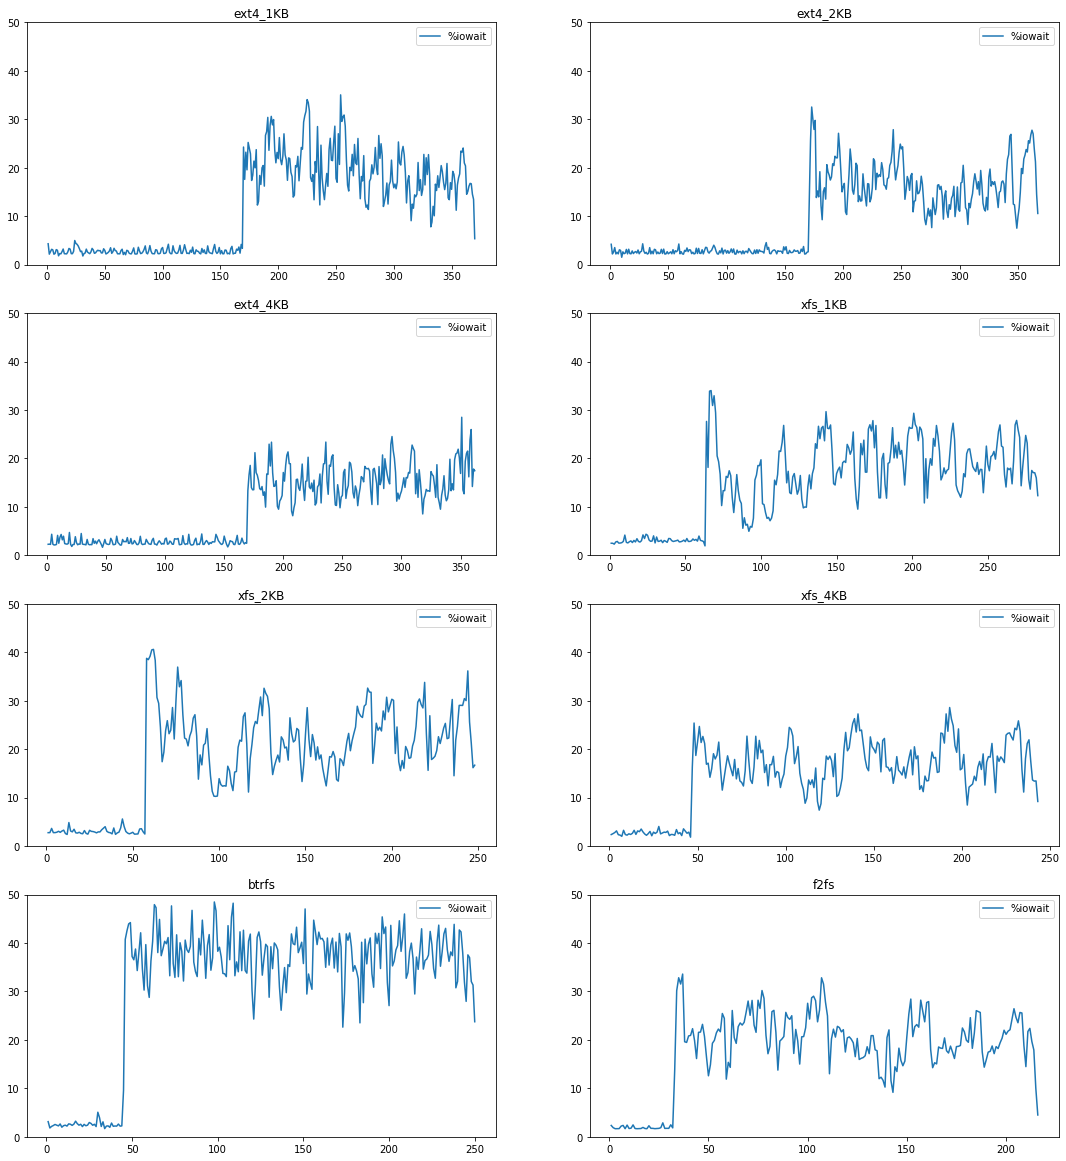

In [25]:
fig, axes = plt.subplots(nrows=4, ncols=2)

oh['ext4_1KB'][1:][['%iowait']].plot(ax=axes[0, 0], title="ext4_1KB")
oh['ext4_2KB'][1:][['%iowait']].plot(ax=axes[0, 1], title="ext4_2KB")
oh['ext4_default_4KB'][1:][['%iowait']].plot(ax=axes[1, 0], title="ext4_4KB")
oh['xfs_1KB'][1:][['%iowait']].plot(ax=axes[1, 1], title="xfs_1KB")
oh['xfs_2KB'][1:][['%iowait']].plot(ax=axes[2, 0], title="xfs_2KB")
oh['xfs_default_4KB'][1:][['%iowait']].plot(ax=axes[2, 1], title="xfs_4KB")
oh['btrfs_default_4KB'][1:][['%iowait']].plot(ax=axes[3, 0], title="btrfs")
oh['f2fs_default_512k'][1:][['%iowait']].plot(ax=axes[3, 1], title="f2fs")

custom_xlim = (0, 300)
custom_ylim = (0, 50)
plt.setp(axes, ylim=custom_ylim)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 20.5)

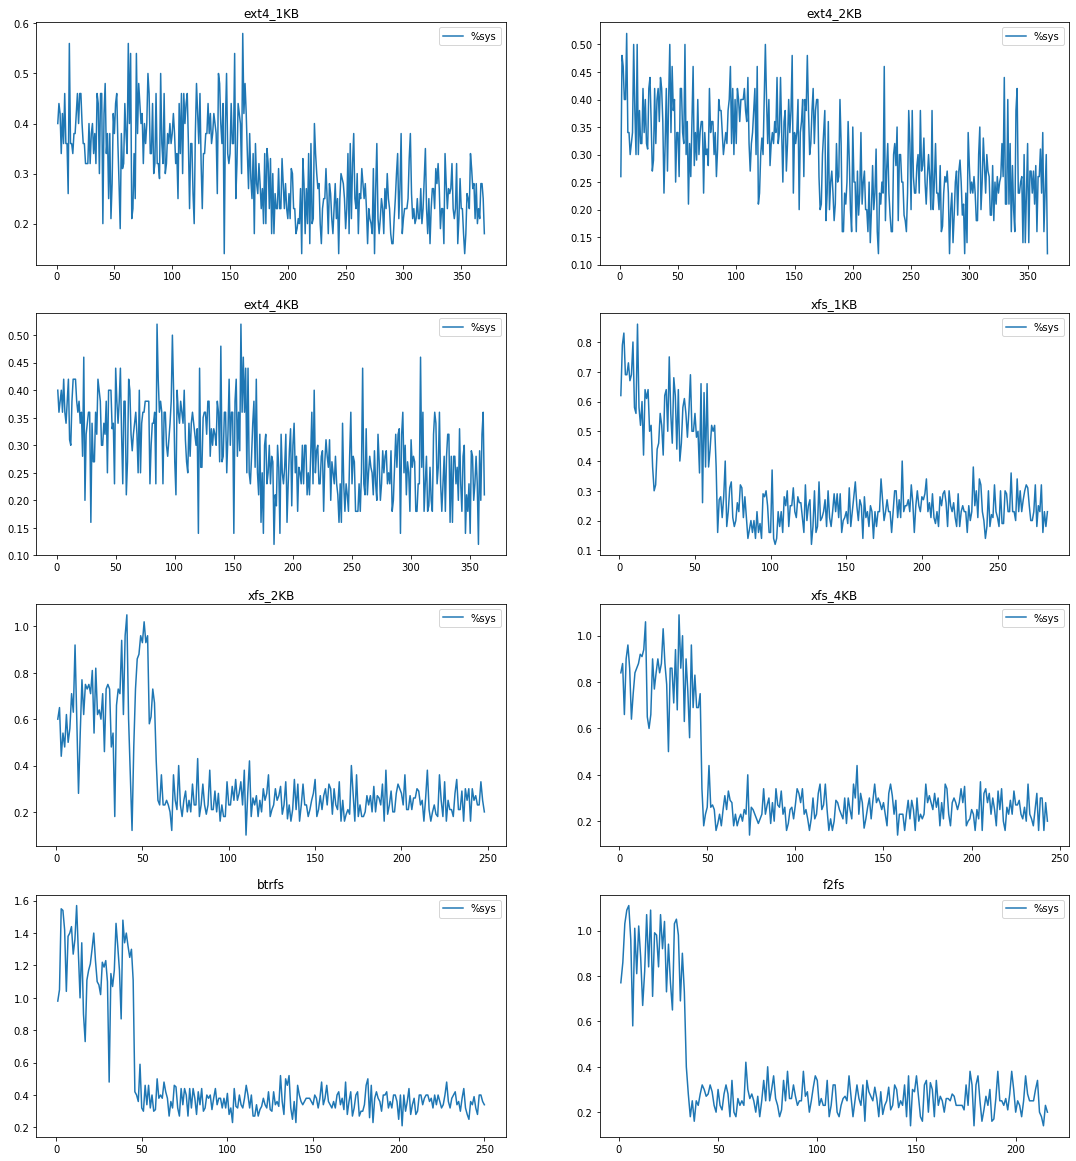

In [27]:
fig, axes = plt.subplots(nrows=4, ncols=2)

oh['ext4_1KB'][1:][['%sys']].plot(ax=axes[0, 0], title="ext4_1KB")
oh['ext4_2KB'][1:][['%sys']].plot(ax=axes[0, 1], title="ext4_2KB")
oh['ext4_default_4KB'][1:][['%sys']].plot(ax=axes[1, 0], title="ext4_4KB")
oh['xfs_1KB'][1:][['%sys']].plot(ax=axes[1, 1], title="xfs_1KB")
oh['xfs_2KB'][1:][['%sys']].plot(ax=axes[2, 0], title="xfs_2KB")
oh['xfs_default_4KB'][1:][['%sys']].plot(ax=axes[2, 1], title="xfs_4KB")
oh['btrfs_default_4KB'][1:][['%sys']].plot(ax=axes[3, 0], title="btrfs")
oh['f2fs_default_512k'][1:][['%sys']].plot(ax=axes[3, 1], title="f2fs")

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 20.5)